In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
import random as rd
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold
from sklearn.metrics import roc_auc_score, roc_curve, plot_roc_curve
import matplotlib.pyplot as plt

%matplotlib inline

# Descriptive analysis of public data

(c) Junqui Liu and Carlos Contreras, March 2021

In [2]:
data = pd.read_csv('../../data/AHS Public/covid19dataexport.csv')
data['Date reported'] = pd.to_datetime(data['Date reported'], format='%Y-%m-%d')

In [3]:
data.head()

,Date reported,Alberta Health Services Zone,Gender,Age group,Case status,Case type
0,2020-11-13,Calgary Zone,Female,1-4 years,Recovered,Confirmed
1,2021-01-03,Calgary Zone,Female,5-9 years,Recovered,Confirmed
2,2020-12-13,Edmonton Zone,Male,5-9 years,Recovered,Confirmed
3,2021-01-05,Central Zone,Male,50-59 years,Recovered,Confirmed
4,2021-01-30,Calgary Zone,Female,1-4 years,Recovered,Confirmed


In [4]:
for col in data.columns[1:]:
    print(col, ': ', data[col].unique())

Alberta Health Services Zone :  ['Calgary Zone' 'Edmonton Zone' 'Central Zone' 'North Zone' 'South Zone'
 'Unknown']
Gender :  ['Female' 'Male' 'Unknown']
Age group :  ['1-4 years' '5-9 years' '50-59 years' 'Under 1 year' '10-19 years'
 '40-49 years' '20-29 years' '30-39 years' '60-69 years' '80+ years'
 '70-79 years' 'Unknown']
Case status :  ['Recovered' 'Active' 'Died']
Case type :  ['Confirmed' 'Probable']


In [5]:
data[data['Case status'] == 'Died']

,Date reported,Alberta Health Services Zone,Gender,Age group,Case status,Case type
426,2020-08-29,North Zone,Female,50-59 years,Died,Confirmed
6079,2021-01-20,North Zone,Male,60-69 years,Died,Confirmed
7529,2020-12-27,North Zone,Male,40-49 years,Died,Confirmed
7747,2021-01-01,Central Zone,Female,20-29 years,Died,Confirmed
8669,2020-12-27,North Zone,Female,80+ years,Died,Confirmed
...,...,...,...,...,...,...
139020,2020-12-25,Calgary Zone,Female,80+ years,Died,Confirmed
139022,2021-01-03,Edmonton Zone,Female,80+ years,Died,Confirmed
139036,2020-12-19,Calgary Zone,Male,60-69 years,Died,Confirmed
139041,2020-11-27,Edmonton Zone,Female,80+ years,Died,Confirmed


## Severe cases

In [6]:
data = pd.read_csv('../../data/AHS Public/covid19severeagegroup.csv', skiprows=[1], usecols=[0, 1, 2, 5, 8])
data = data.set_index('Age Group')
data = data.drop(['Total'], axis=0)
data.columns = ['Total', 'Hospitalized','ICU', 'Deaths']
data

,Total,Hospitalized,ICU,Deaths
Age Group,,,,
Under 1 year,787,39,10,0
1-4 years,4486,22,4,0
5-9 years,6266,17,9,0
10-19 years,16522,86,10,0
20-29 years,25469,304,30,9
30-39 years,26356,490,57,10
40-49 years,21835,627,112,30
50-59 years,16518,893,207,68
60-69 years,10270,1077,285,197


In [7]:
data.sum()/data['Total'].sum()

Total           1.000000
Hospitalized    0.044796
ICU             0.007230
Deaths          0.014029
dtype: float64

,Total,Hospitalized,ICU,Deaths
Age Group,,,,
Under 1 year,0.005656,0.006257,0.009940,0.000000
1-4 years,0.032240,0.003530,0.003976,0.000000
5-9 years,0.045033,0.002727,0.008946,0.000000
10-19 years,0.118741,0.013798,0.009940,0.000000
20-29 years,0.183042,0.048773,0.029821,0.004611
30-39 years,0.189417,0.078614,0.056660,0.005123
40-49 years,0.156925,0.100594,0.111332,0.015369
50-59 years,0.118712,0.143270,0.205765,0.034836
60-69 years,0.073809,0.172790,0.283300,0.100922


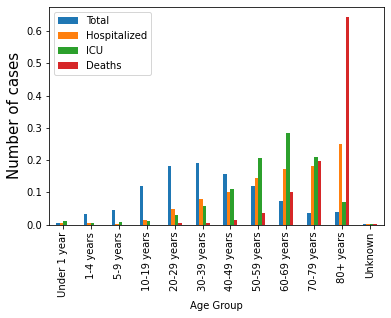

In [8]:
temp = data.div(data.sum(), axis=1)
temp.plot.bar()
plt.ylabel("Number of cases", fontsize=15)
temp

In [9]:
df_severe = temp

## Comorbidities 

In [10]:
data = pd.read_csv('../../data/AHS Public/covid19comorbidities1.csv')
data = data.set_index('Condition')
data

,Count,Percent
Condition,,
Hypertension,1678,86.0%
Cardio-Vascular Diseases,1037,53.1%
Dementia,1013,51.9%
Renal Diseases,895,45.9%
Diabetes,870,44.6%
Respiratory Diseases,797,40.8%
Cancer,446,22.8%
Stroke,413,21.2%
Liver Diseases,76,3.9%


We will assume those percentages are amoung deaths and hopitalizations

,Count,Percent
Condition,,
Hypertension,0.231098,0.231183
Cardio-Vascular Diseases,0.142818,0.142742
Dementia,0.139512,0.139516
Renal Diseases,0.123261,0.123387
Diabetes,0.119818,0.119892
Respiratory Diseases,0.109764,0.109677
Cancer,0.061424,0.061290
Stroke,0.056879,0.056989
Liver Diseases,0.010467,0.010484


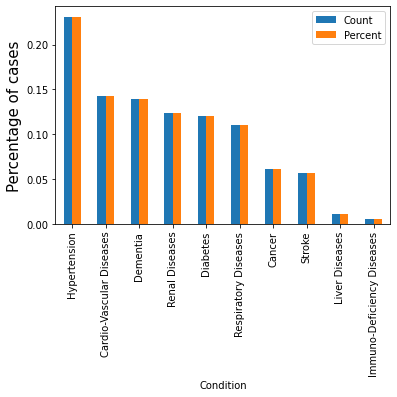

In [11]:
temp = pd.concat((data[['Count']], data['Percent'].str.rstrip('%').astype('float')/100), axis=1)
temp = temp.div(temp.sum(), axis=1)
temp.plot.bar()
plt.ylabel("Percentage of cases", fontsize=15)
temp

In [12]:
# temp = pd.concat((data[['Count']], data['Percent'].str.rstrip('%').astype('float')/100), axis=1)
df_comorb1 = temp

Percent is the precentage of cases 

In [13]:
pd.read_csv('../../data/AHS Public/covid19comorbidities2.csv')

,Number of conditions,Non-Severe,Unnamed: 2,Non-ICU,Unnamed: 4,ICU,Unnamed: 6,Deaths,Unnamed: 8
0,NaN,Number,Percent,Number,Percent,Number,Percent,Number,Percent
1,No comorbidity,88819,67.2%,959,21.8%,141,19.4%,58,3.0%
2,With 1 condition,26634,20.2%,769,17.5%,152,20.9%,140,7.2%
3,With 2 conditions,9202,7.0%,796,18.1%,181,24.9%,257,13.2%
4,With 3 or more conditions,7420,5.6%,1866,42.5%,252,34.7%,1497,76.7%


,Non-Severe,Non-ICU,ICU,Deaths
Number of conditions,,,,
No comorbidity,88819,959,141,58
With 1 condition,26634,769,152,140
With 2 conditions,9202,796,181,257
With 3 or more conditions,7420,1866,252,1497


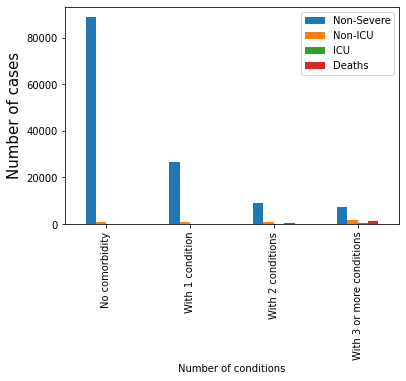

In [14]:
data = pd.read_csv('../../data/AHS Public/covid19comorbidities2.csv', skiprows=[1], usecols=[0, 1, 3, 5, 7])
data = data.set_index('Number of conditions')
data.plot.bar()
plt.ylabel("Number of cases", fontsize=15)
data

In [15]:
data.sum()

Non-Severe    132075
Non-ICU         4390
ICU              726
Deaths          1952
dtype: int64

,Non-Severe,Non-ICU,ICU,Deaths
Number of conditions,,,,
No comorbidity,0.672489,0.218451,0.194215,0.029713
With 1 condition,0.201658,0.175171,0.209366,0.071721
With 2 conditions,0.069673,0.181321,0.249311,0.131660
With 3 or more conditions,0.056180,0.425057,0.347107,0.766906


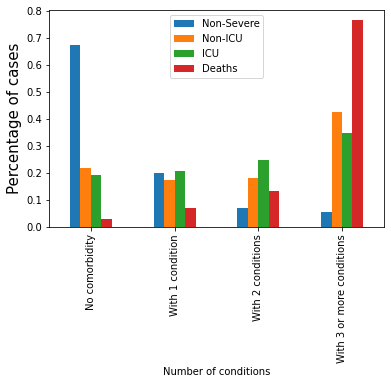

In [16]:
temp = data.div(data.sum(), axis=1)
temp.plot.bar()
plt.ylabel("Percentage of cases", fontsize=15)
temp

In [17]:
df_comorb2 = temp

# Synthetic data

In [18]:
data = pd.read_csv('../../data/AHS Public/covid19dataexport.csv')
data['Date reported'] = pd.to_datetime(data['Date reported'], format='%Y-%m-%d')

Synthetic features:

- Oxygen saturation
- D-dimer count
- C reactive protein

In [19]:
def oxygen_saturation(x):
    # percentage
    gender = ['Female', 'Male', 'Unknown']
    ages = ['Under 1 year', '1-4 years', '5-9 years', '10-19 years', '20-29 years',
       '30-39 years', '40-49 years', '50-59 years', '60-69 years',
       '70-79 years', '80+ years', 'Unknown']
    mus = [[97, 97, 97, 96, 96, 96, 96, 95, 94, 94, 92, 96],
             [97, 97, 97, 96, 96, 96, 96, 95, 94, 93, 91, 96],
             [97, 97, 97, 96, 96, 96, 96, 95, 94, 94, 91, 96]]
    sigmas =  [[.8, .8, .8, .8, .9, .9, .9, 1.1, 1.1, 1.7, 1.9, 1.1],
             [.8, .8, .8, .8, .9, .9, .9, 1.1, 1.1, 1.8, 2.1, 1.1],
             [.8, .8, .8, .8, .9, .9, .9, 1.1, 1.1, 1.7, 1.7, 1.1]]
    ix1 = gender.index(x['Gender'])
    ix2 = ages.index(x['Age group'])
    value = rd.gauss(mu=mus[ix1][ix2], sigma=sigmas[ix1][ix2])
    value -= rd.random() if x['Case status']=='Died' else 0
    return np.round(np.minimum(value, 99.9), 1)

def d_dimer(x):
    # ng/mL
    gender = ['Female', 'Male', 'Unknown']
    ages = ['Under 1 year', '1-4 years', '5-9 years', '10-19 years', '20-29 years',
       '30-39 years', '40-49 years', '50-59 years', '60-69 years',
       '70-79 years', '80+ years', 'Unknown']
    mus = [[294, 294, 294, 294, 294, 294, 387, 387, 454, 554, 690, 400],
           [294, 294, 294, 294, 294, 294, 387, 387, 454, 554, 760, 400],
           [294, 294, 294, 294, 294, 294, 387, 387, 454, 554, 800, 400]]
    sigmas = [[40, 40, 40, 40, 50, 50, 70, 80, 80, 80, 100, 50],
              [40, 40, 40, 40, 50, 50, 70, 80, 80, 80, 100, 50],
              [40, 40, 40, 40, 50, 50, 70, 80, 80, 80, 100, 50]]
    ix1 = gender.index(x['Gender'])
    ix2 = ages.index(x['Age group'])
    value = rd.gauss(mu=mus[ix1][ix2], sigma=sigmas[ix1][ix2])
    value += rd.gauss(mu=2, sigma=5) if x['Case status']=='Died' else 0
    return np.round(value, 0)

def c_reactive(x):
    # mg/L
    # https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4863028/
    gender = ['Female', 'Male', 'Unknown']
    ages = ['Under 1 year', '1-4 years', '5-9 years', '10-19 years', '20-29 years',
       '30-39 years', '40-49 years', '50-59 years', '60-69 years',
       '70-79 years', '80+ years', 'Unknown']
    mus = [[0.92, 0.92, 0.92, 0.92, 0.92, 0.92, 0.92, 0.92, 1.04, 1.04, 1.04, np.nan],
             [0.92, 0.92, 0.92, 0.92, 0.92, 0.92, 0.92, 0.92, 1.04, 1.14, 1.14, np.nan],
             [0.92, 0.92, 0.92, 0.92, 0.92, 0.92, 0.92, 0.92, 1.04, 1.04, 1.04, np.nan]]
    sigmas =  [[0.17, 0.17, 0.17, 0.17, 0.17, 0.17, 0.17, 0.17, 0.28, 0.28, 0.28, np.nan],
             [0.17, 0.17, 0.17, 0.17, 0.17, 0.17, 0.17, 0.17, 0.28, 0.28, 0.28, np.nan],
             [0.17, 0.17, 0.17, 0.17, 0.17, 0.17, 0.17, 0.17, 0.28, 0.28, 0.28, np.nan]]
    ix1 = gender.index(x['Gender'])
    ix2 = ages.index(x['Age group'])
    value = rd.gauss(mu=mus[ix1][ix2], sigma=sigmas[ix1][ix2])
    value += rd.gauss(mu=0, sigma=.1) if x['Case status']=='Died' else 0
    return np.round(value, 2)

All synthetic feartures

In [20]:
df_comorb1

,Count,Percent
Condition,,
Hypertension,0.231098,0.231183
Cardio-Vascular Diseases,0.142818,0.142742
Dementia,0.139512,0.139516
Renal Diseases,0.123261,0.123387
Diabetes,0.119818,0.119892
Respiratory Diseases,0.109764,0.109677
Cancer,0.061424,0.061290
Stroke,0.056879,0.056989
Liver Diseases,0.010467,0.010484


In [21]:
n = 2


In [22]:
def synthetic_information(x):
    value = []
    index = ['Hospitalized','ICU','Number of comorbidities',
             'Hypertension', 'Cardio-Vascular Diseases', 'Dementia',
             'Renal Diseases', 'Diabetes', 'Respiratory Diseases', 'Cancer',
             'Stroke', 'Liver Diseases', 'Immuno-Deficiency Diseases', 
             'Admission date',
             'Oxygen saturation', 'D-Dimer', 'C reactive']
    # Hospitalized
    p = rd.random()*1/12
    value.append((df_severe['Hospitalized'][x['Age group']]*0.044796>p) | (x['Case status']=='Died'))
    # ICU
    value.append(df_severe['ICU'][x['Age group']]*0.007230>p)
    # Comorbodities
    p = rd.random()
    # Number
    if (x['Case status']=='Died'):
        value.append(sum(df_comorb2.cumsum(axis=0)['Deaths'] < p))
    elif value[1]:
        value.append(sum(df_comorb2.cumsum(axis=0)['ICU'] < p))
    elif value[0]:
        value.append(sum(df_comorb2.cumsum(axis=0)['Non-ICU'] < p))
    else:
        value.append(sum(df_comorb2.cumsum(axis=0)['Non-Severe'] < p))
    # Separate comorbidities
    com = np.random.choice(df_comorb1.index, 2, replace=True, p=df_comorb1['Count'].values)
    for ix in index[3:13]:
        if ix in com:
            value.append(True)
        else:
            value.append(False)
    if (value[0] | value[1]):
        # Admission date
        value.append(x['Date reported']+pd.DateOffset(rd.randrange(7)))
        # Oxygen saturation
        value.append(oxygen_saturation(x))
        # D-dimer
        value.append(d_dimer(x))
        # Oxygen saturation
        value.append(oxygen_saturation(x))
    else:
        value.append(np.nan)
        value.append(np.nan)
        value.append(np.nan)
        value.append(np.nan)
    y = pd.Series(value, index=index)
    return x.append(y)

In [23]:
data

,Date reported,Alberta Health Services Zone,Gender,Age group,Case status,Case type
0,2020-11-13,Calgary Zone,Female,1-4 years,Recovered,Confirmed
1,2021-01-03,Calgary Zone,Female,5-9 years,Recovered,Confirmed
2,2020-12-13,Edmonton Zone,Male,5-9 years,Recovered,Confirmed
3,2021-01-05,Central Zone,Male,50-59 years,Recovered,Confirmed
4,2021-01-30,Calgary Zone,Female,1-4 years,Recovered,Confirmed
...,...,...,...,...,...,...
139138,2020-10-13,Calgary Zone,Female,10-19 years,Recovered,Confirmed
139139,2020-11-20,Calgary Zone,Female,30-39 years,Recovered,Confirmed
139140,2020-11-19,Calgary Zone,Male,30-39 years,Recovered,Confirmed
139141,2020-11-13,Calgary Zone,Male,40-49 years,Recovered,Confirmed


In [24]:
synthetic = data.apply(synthetic_information, axis=1)

Save synthetic data

In [25]:
synthetic.to_csv('covid19syntheticdata.csv')

# Gradient boosting classifier

## Load and process data

In [26]:
df = pd.read_csv('covid19syntheticdata.csv', index_col=0, na_values='Unknown')
df['Date reported'] = pd.to_datetime(df['Date reported'], format='%Y-%m-%d')
df['Admission date'] = pd.to_datetime(df['Admission date'], format='%Y-%m-%d')

In [27]:
df.head()

,Date reported,Alberta Health Services Zone,Gender,Age group,Case status,Case type,Hospitalized,ICU,Number of comorbidities,Hypertension,...,Diabetes,Respiratory Diseases,Cancer,Stroke,Liver Diseases,Immuno-Deficiency Diseases,Admission date,Oxygen saturation,D-Dimer,C reactive
0,2020-11-13,Calgary Zone,Female,1-4 years,Recovered,Confirmed,False,False,0,True,...,False,False,False,False,False,False,NaT,NaN,NaN,NaN
1,2021-01-03,Calgary Zone,Female,5-9 years,Recovered,Confirmed,False,False,2,False,...,False,False,True,False,False,False,NaT,NaN,NaN,NaN
2,2020-12-13,Edmonton Zone,Male,5-9 years,Recovered,Confirmed,False,False,0,False,...,True,True,False,False,False,False,NaT,NaN,NaN,NaN
3,2021-01-05,Central Zone,Male,50-59 years,Recovered,Confirmed,False,False,1,False,...,False,False,False,False,False,False,NaT,NaN,NaN,NaN
4,2021-01-30,Calgary Zone,Female,1-4 years,Recovered,Confirmed,False,False,0,True,...,False,False,False,False,False,False,NaT,NaN,NaN,NaN


In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 139143 entries, 0 to 139142
Data columns (total 23 columns):
 #   Column                        Non-Null Count   Dtype         
---  ------                        --------------   -----         
 0   Date reported                 139143 non-null  datetime64[ns]
 1   Alberta Health Services Zone  139030 non-null  object        
 2   Gender                        139076 non-null  object        
 3   Age group                     139070 non-null  object        
 4   Case status                   139143 non-null  object        
 5   Case type                     139143 non-null  object        
 6   Hospitalized                  139143 non-null  bool          
 7   ICU                           139143 non-null  bool          
 8   Number of comorbidities       139143 non-null  int64         
 9   Hypertension                  139143 non-null  bool          
 10  Cardio-Vascular Diseases      139143 non-null  bool          
 11  Dementia     

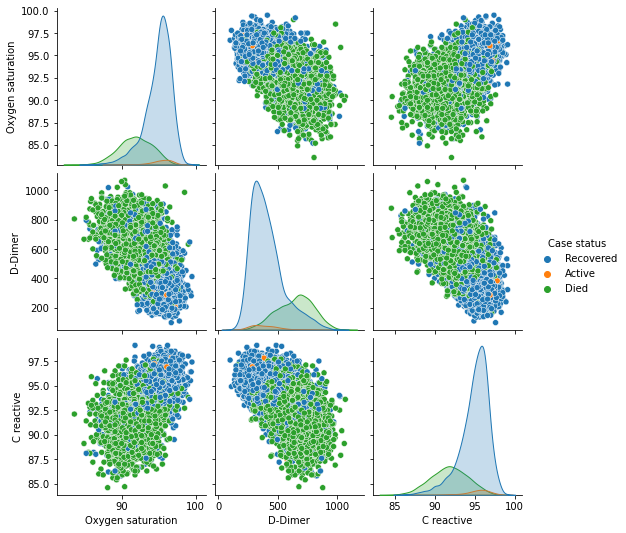

In [29]:
sns.pairplot(data=df, vars=['Oxygen saturation', 'D-Dimer', 'C reactive'], hue="Case status")

### Data cleaning: filter cases of interest

Remove active, unconfirmed, and non-hospitalized, non-ICU cases.

In [30]:
df = df[df['Case status'] != 'Active']
df = df[df['Case type'] == 'Confirmed']
df = df[df['ICU'] | df['Hospitalized']]

Drop na's

In [31]:
df.dropna(axis=0, inplace=True)

In [32]:
df[df['Case status']=='Died']

,Date reported,Alberta Health Services Zone,Gender,Age group,Case status,Case type,Hospitalized,ICU,Number of comorbidities,Hypertension,...,Diabetes,Respiratory Diseases,Cancer,Stroke,Liver Diseases,Immuno-Deficiency Diseases,Admission date,Oxygen saturation,D-Dimer,C reactive
426,2020-08-29,North Zone,Female,50-59 years,Died,Confirmed,True,False,0,True,...,False,True,False,False,False,False,2020-08-29,94.9,392.0,95.5
6079,2021-01-20,North Zone,Male,60-69 years,Died,Confirmed,True,False,3,False,...,False,False,False,False,False,False,2021-01-26,94.7,381.0,92.5
7529,2020-12-27,North Zone,Male,40-49 years,Died,Confirmed,True,False,3,True,...,False,True,False,False,False,False,2020-12-28,95.7,430.0,95.4
7747,2021-01-01,Central Zone,Female,20-29 years,Died,Confirmed,True,False,0,True,...,False,True,False,False,False,False,2021-01-03,94.1,215.0,95.7
8669,2020-12-27,North Zone,Female,80+ years,Died,Confirmed,True,False,3,False,...,False,False,True,False,False,False,2020-12-31,92.7,754.0,90.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139020,2020-12-25,Calgary Zone,Female,80+ years,Died,Confirmed,True,False,2,False,...,False,False,False,False,False,False,2020-12-26,90.5,593.0,91.7
139022,2021-01-03,Edmonton Zone,Female,80+ years,Died,Confirmed,True,False,3,False,...,False,True,False,False,False,False,2021-01-08,90.6,635.0,90.2
139036,2020-12-19,Calgary Zone,Male,60-69 years,Died,Confirmed,True,False,3,True,...,False,False,False,False,False,False,2020-12-24,92.5,435.0,92.5
139041,2020-11-27,Edmonton Zone,Female,80+ years,Died,Confirmed,True,False,3,False,...,True,False,False,False,False,False,2020-12-03,92.3,815.0,90.8


### Data processing: create extra features and re-lable categories

Gender

In [33]:
df['Gender'] = df['Gender'].astype('category')
df['Gender code'] = df['Gender'].cat.codes

In [34]:
df[df['Case status']=='Died']

,Date reported,Alberta Health Services Zone,Gender,Age group,Case status,Case type,Hospitalized,ICU,Number of comorbidities,Hypertension,...,Respiratory Diseases,Cancer,Stroke,Liver Diseases,Immuno-Deficiency Diseases,Admission date,Oxygen saturation,D-Dimer,C reactive,Gender code
426,2020-08-29,North Zone,Female,50-59 years,Died,Confirmed,True,False,0,True,...,True,False,False,False,False,2020-08-29,94.9,392.0,95.5,0
6079,2021-01-20,North Zone,Male,60-69 years,Died,Confirmed,True,False,3,False,...,False,False,False,False,False,2021-01-26,94.7,381.0,92.5,1
7529,2020-12-27,North Zone,Male,40-49 years,Died,Confirmed,True,False,3,True,...,True,False,False,False,False,2020-12-28,95.7,430.0,95.4,1
7747,2021-01-01,Central Zone,Female,20-29 years,Died,Confirmed,True,False,0,True,...,True,False,False,False,False,2021-01-03,94.1,215.0,95.7,0
8669,2020-12-27,North Zone,Female,80+ years,Died,Confirmed,True,False,3,False,...,False,True,False,False,False,2020-12-31,92.7,754.0,90.4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139020,2020-12-25,Calgary Zone,Female,80+ years,Died,Confirmed,True,False,2,False,...,False,False,False,False,False,2020-12-26,90.5,593.0,91.7,0
139022,2021-01-03,Edmonton Zone,Female,80+ years,Died,Confirmed,True,False,3,False,...,True,False,False,False,False,2021-01-08,90.6,635.0,90.2,0
139036,2020-12-19,Calgary Zone,Male,60-69 years,Died,Confirmed,True,False,3,True,...,False,False,False,False,False,2020-12-24,92.5,435.0,92.5,1
139041,2020-11-27,Edmonton Zone,Female,80+ years,Died,Confirmed,True,False,3,False,...,False,False,False,False,False,2020-12-03,92.3,815.0,90.8,0


Compute the number of days between report and admission

In [35]:
df['Days to admission'] = (df['Admission date'] - df['Date reported']).dt.days

Age group

In [36]:
df['Age group code'] = df['Age group'].replace({'Under 1 year': 0,
                                                '1-4 years': 1,
                                                '5-9 years': 5,
                                                '10-19 years': 10,
                                                '20-29 years': 20,
                                                '30-39 years': 30,
                                                '40-49 years': 40,
                                                '50-59 years': 50,
                                                '60-69 years': 60,
                                                '70-79 years': 70,
                                                '80+ years': 80})

Comorbidities

In [37]:
for col in ['Hospitalized', 'ICU', 'Hypertension',
       'Cardio-Vascular Diseases', 'Dementia', 'Renal Diseases', 'Diabetes',
       'Respiratory Diseases', 'Cancer', 'Stroke', 'Liver Diseases',
       'Immuno-Deficiency Diseases']:
    df[col+' code'] = np.where(df[col] == True, 1, 0)

Compute the sum of comorbodities

In [38]:
df['Number of comorbidities2'] = df[['Hypertension', 'Cardio-Vascular Diseases', 'Dementia',
       'Renal Diseases', 'Diabetes', 'Respiratory Diseases', 'Cancer',
       'Stroke', 'Liver Diseases', 'Immuno-Deficiency Diseases']].sum(axis=1)

Output variable: case status

In [39]:
df['Case status code'] = df['Case status'].replace({'Recovered': 0, 'Died':1})

In [40]:
df[df['Case status code']==1]

,Date reported,Alberta Health Services Zone,Gender,Age group,Case status,Case type,Hospitalized,ICU,Number of comorbidities,Hypertension,...,Dementia code,Renal Diseases code,Diabetes code,Respiratory Diseases code,Cancer code,Stroke code,Liver Diseases code,Immuno-Deficiency Diseases code,Number of comorbidities2,Case status code
426,2020-08-29,North Zone,Female,50-59 years,Died,Confirmed,True,False,0,True,...,0,0,0,1,0,0,0,0,2,1
6079,2021-01-20,North Zone,Male,60-69 years,Died,Confirmed,True,False,3,False,...,1,0,0,0,0,0,0,0,1,1
7529,2020-12-27,North Zone,Male,40-49 years,Died,Confirmed,True,False,3,True,...,0,0,0,1,0,0,0,0,2,1
7747,2021-01-01,Central Zone,Female,20-29 years,Died,Confirmed,True,False,0,True,...,0,0,0,1,0,0,0,0,2,1
8669,2020-12-27,North Zone,Female,80+ years,Died,Confirmed,True,False,3,False,...,0,0,0,0,1,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139020,2020-12-25,Calgary Zone,Female,80+ years,Died,Confirmed,True,False,2,False,...,1,1,0,0,0,0,0,0,2,1
139022,2021-01-03,Edmonton Zone,Female,80+ years,Died,Confirmed,True,False,3,False,...,0,0,0,1,0,0,0,0,2,1
139036,2020-12-19,Calgary Zone,Male,60-69 years,Died,Confirmed,True,False,3,True,...,0,0,0,0,0,0,0,0,2,1
139041,2020-11-27,Edmonton Zone,Female,80+ years,Died,Confirmed,True,False,3,False,...,0,0,1,0,0,0,0,0,2,1


Resulting data frame

In [41]:
df.head(10)

,Date reported,Alberta Health Services Zone,Gender,Age group,Case status,Case type,Hospitalized,ICU,Number of comorbidities,Hypertension,...,Dementia code,Renal Diseases code,Diabetes code,Respiratory Diseases code,Cancer code,Stroke code,Liver Diseases code,Immuno-Deficiency Diseases code,Number of comorbidities2,Case status code
38,2021-01-21,North Zone,Male,80+ years,Recovered,Confirmed,True,False,0,True,...,0,0,0,0,0,0,0,0,2,0
72,2020-11-17,North Zone,Male,20-29 years,Recovered,Confirmed,True,False,2,False,...,0,1,0,1,0,0,0,0,2,0
81,2020-11-18,Edmonton Zone,Female,80+ years,Recovered,Confirmed,True,False,3,False,...,1,1,0,0,0,0,0,0,2,0
86,2020-11-21,South Zone,Male,20-29 years,Recovered,Confirmed,True,False,3,True,...,1,0,0,0,0,0,0,0,2,0
179,2020-12-13,Calgary Zone,Male,30-39 years,Recovered,Confirmed,True,True,1,False,...,0,0,0,0,0,0,0,0,1,0
231,2020-10-10,Edmonton Zone,Male,20-29 years,Recovered,Confirmed,True,False,3,False,...,0,0,0,0,1,1,0,0,2,0
238,2020-12-31,Calgary Zone,Female,50-59 years,Recovered,Confirmed,True,True,1,False,...,0,0,0,0,0,1,0,0,2,0
253,2020-11-29,Edmonton Zone,Male,40-49 years,Recovered,Confirmed,True,False,3,True,...,0,0,0,0,0,0,0,0,2,0
255,2021-01-11,Edmonton Zone,Female,40-49 years,Recovered,Confirmed,True,False,2,True,...,0,0,0,0,0,0,0,0,2,0
259,2020-11-20,Central Zone,Male,80+ years,Recovered,Confirmed,True,False,3,True,...,0,0,0,0,0,0,0,0,2,0


In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8063 entries, 38 to 139064
Data columns (total 40 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   Date reported                    8063 non-null   datetime64[ns]
 1   Alberta Health Services Zone     8063 non-null   object        
 2   Gender                           8063 non-null   category      
 3   Age group                        8063 non-null   object        
 4   Case status                      8063 non-null   object        
 5   Case type                        8063 non-null   object        
 6   Hospitalized                     8063 non-null   bool          
 7   ICU                              8063 non-null   bool          
 8   Number of comorbidities          8063 non-null   int64         
 9   Hypertension                     8063 non-null   bool          
 10  Cardio-Vascular Diseases         8063 non-null   bool    

In [43]:
df.shape

(8063, 40)

In [44]:
df['Case status code'].value_counts()

0    6114
1    1949
Name: Case status code, dtype: int64

### Built and train classifiers

Input and put data and train/test split

In [45]:
temp = df[['Oxygen saturation',
       'D-Dimer', 'C reactive', 'Gender code', 'Days to admission',
       'Age group code', 'Hospitalized code', 'ICU code',
       'Number of comorbidities', 'Case status code']]
temp.head()

,Oxygen saturation,D-Dimer,C reactive,Gender code,Days to admission,Age group code,Hospitalized code,ICU code,Number of comorbidities,Case status code
38,86.9,527.0,91.7,1,5,80,1,0,0,0
72,95.0,309.0,94.8,1,5,20,1,0,2,0
81,92.6,480.0,94.5,0,6,80,1,0,3,0
86,94.7,280.0,96.8,1,1,20,1,0,3,0
179,96.0,274.0,96.9,1,1,30,1,1,1,0


Train/test split

In [46]:
X, y = temp.iloc[:,:-1], temp.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=876)

In [47]:
print('Death rate in train set: ', y_train.sum()/y_train.size)
print('Death rate in test set', y_test.sum()/y_test.size)

Death rate in train set:  0.24031007751937986
Death rate in test set 0.24736515809051457


Train the classifier using 4 fold cross-validation

In [48]:
xgb_classifier = xgb.XGBClassifier(objective='binary:logistic', 
                                   booster='gbtree',
                                   use_label_encoder=False)

params = {'n_estimators': stats.randint(100, 500),
          'learning_rate': stats.uniform(0.01, 0.1),
          'max_depth': [3, 5, 7, 9, 11, 13]}

n_folds = 4

cv_classifier = RandomizedSearchCV(xgb_classifier, 
                             param_distributions=params, 
                             cv=n_folds,
                             n_iter = 20,
                             scoring = 'roc_auc',
                             verbose=2) #use 1 to turn off verbose
cv_classifier.fit(X_train, y_train, eval_metric='logloss')
classifier=cv_classifier.best_estimator_
print('Best parameters:', cv_classifier.best_params_)
print('Score:', cv_classifier.best_score_)

Fitting 4 folds for each of 20 candidates, totalling 80 fits
[CV] learning_rate=0.10751654239856542, max_depth=5, n_estimators=186 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  learning_rate=0.10751654239856542, max_depth=5, n_estimators=186, total=   0.3s
[CV] learning_rate=0.10751654239856542, max_depth=5, n_estimators=186 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV]  learning_rate=0.10751654239856542, max_depth=5, n_estimators=186, total=   0.3s
[CV] learning_rate=0.10751654239856542, max_depth=5, n_estimators=186 
[CV]  learning_rate=0.10751654239856542, max_depth=5, n_estimators=186, total=   0.5s
[CV] learning_rate=0.10751654239856542, max_depth=5, n_estimators=186 
[CV]  learning_rate=0.10751654239856542, max_depth=5, n_estimators=186, total=   0.3s
[CV] learning_rate=0.061177749402648904, max_depth=3, n_estimators=160 
[CV]  learning_rate=0.061177749402648904, max_depth=3, n_estimators=160, total=   0.1s
[CV] learning_rate=0.061177749402648904, max_depth=3, n_estimators=160 
[CV]  learning_rate=0.061177749402648904, max_depth=3, n_estimators=160, total=   0.1s
[CV] learning_rate=0.061177749402648904, max_depth=3, n_estimators=160 
[CV]  learning_rate=0.061177749402648904, max_depth=3, n_estimators=160, total=   0.1s
[CV] learning_rate=0.061177749402648904, max_depth=3, n_estimators=160 
[CV]  learning_rate=0.061177749402648904, max_depth

[CV]  learning_rate=0.0898256943949595, max_depth=9, n_estimators=172, total=   0.3s
[CV] learning_rate=0.0898256943949595, max_depth=9, n_estimators=172 .
[CV]  learning_rate=0.0898256943949595, max_depth=9, n_estimators=172, total=   0.2s
[CV] learning_rate=0.0898256943949595, max_depth=9, n_estimators=172 .
[CV]  learning_rate=0.0898256943949595, max_depth=9, n_estimators=172, total=   0.3s
[CV] learning_rate=0.07729855558847973, max_depth=5, n_estimators=445 
[CV]  learning_rate=0.07729855558847973, max_depth=5, n_estimators=445, total=   0.4s
[CV] learning_rate=0.07729855558847973, max_depth=5, n_estimators=445 
[CV]  learning_rate=0.07729855558847973, max_depth=5, n_estimators=445, total=   0.4s
[CV] learning_rate=0.07729855558847973, max_depth=5, n_estimators=445 
[CV]  learning_rate=0.07729855558847973, max_depth=5, n_estimators=445, total=   0.4s
[CV] learning_rate=0.07729855558847973, max_depth=5, n_estimators=445 
[CV]  learning_rate=0.07729855558847973, max_depth=5, n_estim

[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:   31.5s finished


Best parameters: {'learning_rate': 0.03794786896602569, 'max_depth': 3, 'n_estimators': 253}
Score: 0.9298403089358496


In [49]:
y_pred = classifier.predict(X_test)
cl_auc = roc_auc_score(y_test, y_pred)
print('Classifier: ROC AUC=%.3f' % (cl_auc))

Classifier: ROC AUC=0.826


## Plots

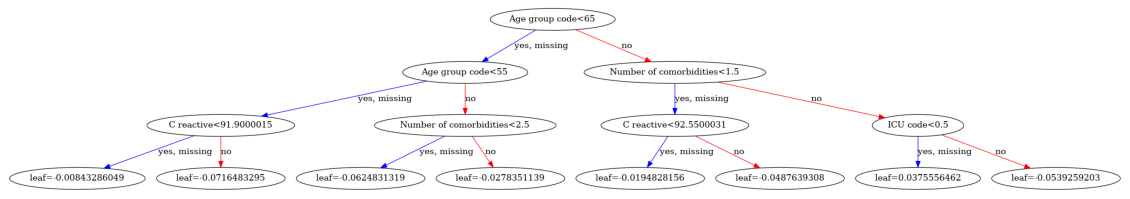

In [50]:
xgb.plot_tree(classifier, num_trees=0, fontsize=10)
fig = plt.gcf()
fig.set_size_inches(20, 10)
plt.show()

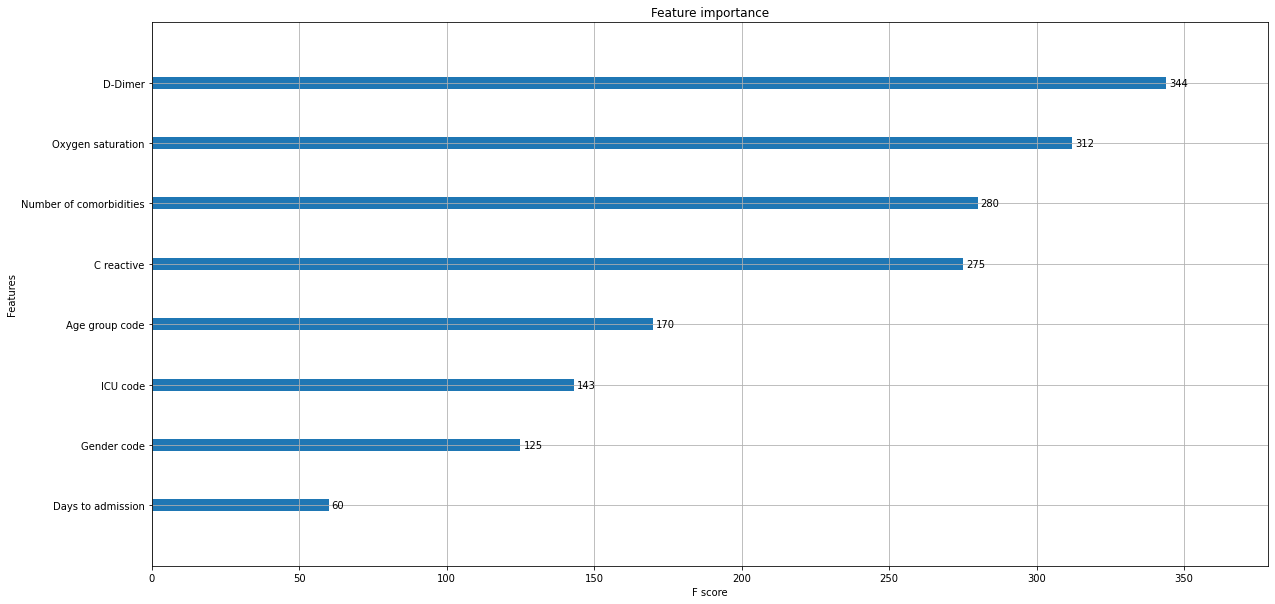

In [51]:
xgb.plot_importance(classifier)
fig = plt.gcf()
fig.set_size_inches(20, 10)
plt.show()

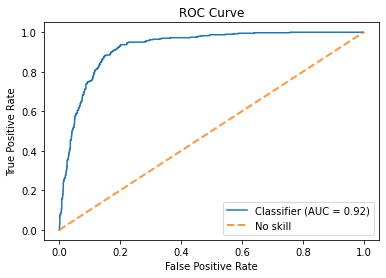

In [52]:
plot_roc_curve(classifier, X_test, y_test, name='Classifier')
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, label='No skill', alpha=.8)
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()